#### Import Necessary Modules: 
**Pandas** - data structure and manipulation  
**Matplotlib, seaborn, and folium** - data visualization  
**shapely** - used to catergorize coordinate cooresponding in district  
**json** - used to read response from FourSquare api  
**requests** - used to send requests to FourSquare api  

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
import json
import numpy as np
import requests
from folium import plugins

#### Read health csv file:
File contains information on a variety of health-related issues in 500 cities around the county.  
The city of greatest interest for this project will be San Antionio, Texas.

In [2]:
cityData = pd.read_csv('500_Cities__Local_Data_for_Better_Health__2018_release.csv')

Physical health being poor for more than 14 days amoung adults will be the metric explored in this project.   

In [3]:
cityHealthDf = cityData[cityData['Measure'] == 'Physical health not good for >=14 days among adults aged >=18 Years']

The three rows of interest: CityName, location, and data_value will be used to construct the first dataframe.   
All rows with duplicate locations or missing data were dropped since they cannot be used in the initial visualization.   

In [4]:
multipleCityHealthDf = cityHealthDf[['CityName', 'GeoLocation', 'Data_Value']].copy()
multipleCityHealthDf = multipleCityHealthDf.dropna()
multipleCityHealthDf.drop_duplicates(subset= 'GeoLocation', inplace=True)
multipleCityHealthDf.reset_index(inplace=True, drop=True)
multipleCityHealthDf.head()

,CityName,GeoLocation,Data_Value
0,Birmingham,"(33.5275663773, -86.7988174678)",16.3
1,Birmingham,"(33.5794328326, -86.7228323926)",20.0
2,Birmingham,"(33.5428208686, -86.752433978)",20.6
3,Birmingham,"(33.5632449633, -86.7640474064)",19.3
4,Birmingham,"(33.5442404594, -86.7749130719)",21.8


Five violin plots are created for five diffeent U.S. cities to show their respective distributions of data.   
San Antonio appears to have its data points spread out more evenly than most of the other major cities.   
Austin, Salt Lake City, and San Francisco in particular appear to have the majority of their data clustered between five and ten percent.

Text(0.5, 1.0, 'Distributions of Poor Health in Different Major U.S. Cities')

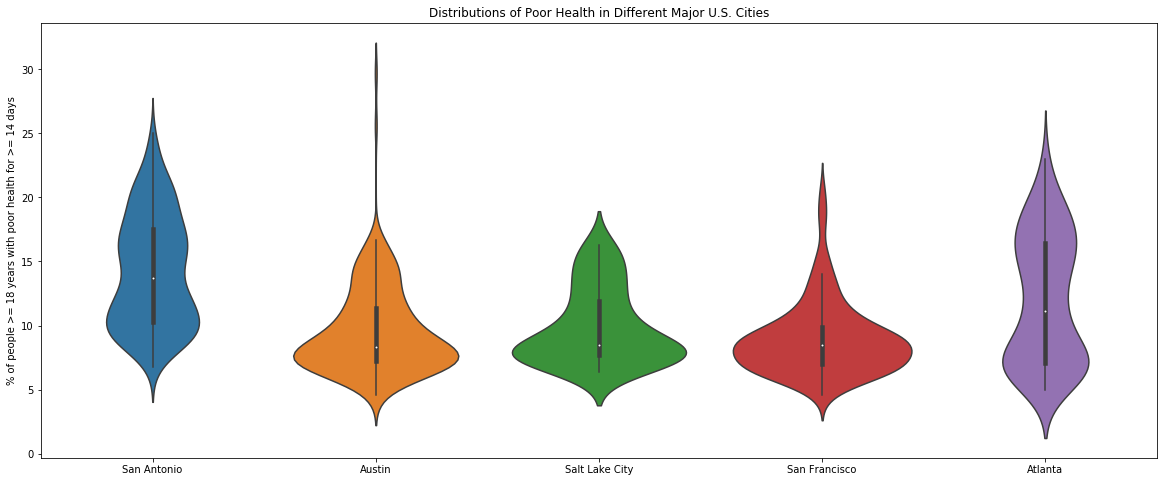

In [5]:
cityHealthValues = {}
cityNames = ['San Antonio', 'Austin', 'Salt Lake City', 'San Francisco', 'Atlanta']

for name in cityNames:
    healthValues = []
    for dataValue in multipleCityHealthDf[multipleCityHealthDf['CityName'] == name]['Data_Value'].values:
        healthValues.append(dataValue)
    cityHealthValues[name] = healthValues

multipleCityGraphDf = pd.DataFrame.from_dict(cityHealthValues, orient='index').transpose()

fig2, ax2 = plt.subplots(figsize=(20, 8))
plot = sns.violinplot(data=multipleCityGraphDf, ax= ax2)

plot.set_ylabel('% of people >= 18 years with poor health for >= 14 days')
plot.set_title('Distributions of Poor Health in Different Major U.S. Cities')

Narrow the dataFrame down to San Antonio since it will be the model for this project

In [6]:
sanAntonioHealthDf = cityHealthDf[cityHealthDf['CityName'] == 'San Antonio']

Take the data of interest (city name, location, and value), drop duplicates and nan values, and split geolocation into latitude and longitude columns

In [7]:
sanAntonioHealthDf = sanAntonioHealthDf[['CityName', 'GeoLocation', 'Data_Value']].copy()
sanAntonioHealthDf.drop_duplicates(subset= 'GeoLocation', inplace=True)
sanAntonioHealthDf.dropna()
sanAntonioHealthDf.reset_index(inplace=True, drop=True)

formatedGeoLocations = sanAntonioHealthDf['GeoLocation'].str.split(',', expand=True)
latitudes = pd.to_numeric(formatedGeoLocations[0].str.strip('('))
longitudes = pd.to_numeric(formatedGeoLocations[1].str.strip(')'))
sanAntonioHealthDf['latitudes'] = latitudes
sanAntonioHealthDf['longitudes'] = longitudes
sanAntonioHealthDf = sanAntonioHealthDf.drop(columns=['GeoLocation'])
sanAntonioHealthDf = sanAntonioHealthDf.rename(columns={'Data_Value':'Percent with Poor Health'})
sanAntonioHealthDf.head()

,CityName,Percent with Poor Health,latitudes,longitudes
0,San Antonio,14.4,29.472148,-98.524676
1,San Antonio,14.0,29.426620,-98.490747
2,San Antonio,15.3,29.414333,-98.480856
3,San Antonio,25.0,29.417401,-98.508888
4,San Antonio,19.9,29.430224,-98.507491


Create a box plot of the San Antonio health data so its distribution can be viewed more clearly

Text(0.5, 0, 'San Antonio')

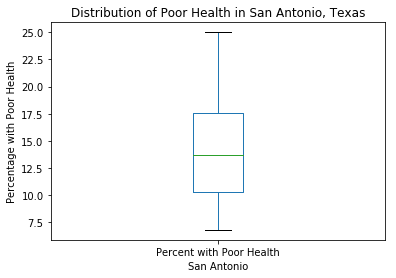

In [8]:
sanAntonioDistribution = sanAntonioHealthDf['Percent with Poor Health'].plot(kind='box', title='Distribution of Poor Health in San Antonio, Texas')
sanAntonioDistribution.set_ylabel('Percentage with Poor Health')
sanAntonioDistribution.set_xlabel('San Antonio')

Create points out of all the longitudes and latitudes

In [9]:
coordinateList = [list(sanAntonioHealthDf['longitudes'].values), list(sanAntonioHealthDf['latitudes'].values)]
coordinatePoints = []
for latitude, longitude in zip(coordinateList[1], coordinateList[0]):
    coordinatePoints.append(Point((longitude, latitude)))

create polygons out of all the bounding coordinates in the geojson file for San Antonio districts

In [10]:
polygons = []
polygonCoordinates = []

with open('Council_Districts.geojson', 'r') as mapData:
    mapJSONDict = json.load(mapData)
    for feature in mapJSONDict['features']:
        
        shapeCoordinates = feature['geometry']['coordinates'][0]
        shapeCoordinates = [tuple(coordinate) for coordinate in shapeCoordinates]
        polygonCoordinates.append(shapeCoordinates)
    
    polygon4List = []
    for coordinateBranch in mapJSONDict['features'][4]['geometry']['coordinates']:
           polygon4List.extend(coordinateBranch[0])
    
    polygonCoordinates[4] = polygon4List
    
    polygon6List = []
    for coordinateBranch in mapJSONDict['features'][6]['geometry']['coordinates']:
           polygon6List.extend(coordinateBranch[0])

    polygonCoordinates[6] = polygon6List

In [11]:
for coordinateSystem in polygonCoordinates:
    polygons.append(Polygon(coordinateSystem))
    

Determine which coordinate points lie in which polygon so that a district label can be attached to each row

In [12]:
districtNames = ['Clayton H. Perry', 'Ana E. Sandoval', 'Manny Pelaez', 'Greg Brockhouse', 'Rebecca J. Viagran',
                'John Courage', 'Art A. Hall', 'Roberto C. Trevino', 'Rey Saldana', 'Shirley Gonzales']

coordinateDistricts = []

for point in coordinatePoints:
    pointDistances = []
    for polygon in polygons:
        pointDistances.append(point.distance(polygon))
        
    coordinateDistricts.append(districtNames[pointDistances.index(min(pointDistances))])
    

Add a district representative column that signifies which district each of the data points was taken in

In [13]:
sanAntonioHealthDf['district_Representative'] = coordinateDistricts
sanAntonioHealthDf.head()

,CityName,Percent with Poor Health,latitudes,longitudes,district_Representative
0,San Antonio,14.4,29.472148,-98.524676,Roberto C. Trevino
1,San Antonio,14.0,29.426620,-98.490747,Roberto C. Trevino
2,San Antonio,15.3,29.414333,-98.480856,Roberto C. Trevino
3,San Antonio,25.0,29.417401,-98.508888,Shirley Gonzales
4,San Antonio,19.9,29.430224,-98.507491,Shirley Gonzales


Group by each of the data points district and take the mean so that a choropleth map can be created

In [14]:
averageHealthDf = sanAntonioHealthDf.groupby('district_Representative').mean().reset_index()
averageHealthDf.head()

,district_Representative,Percent with Poor Health,latitudes,longitudes
0,Ana E. Sandoval,12.985294,29.494596,-98.603813
1,Art A. Hall,16.542857,29.450455,-98.399643
2,Clayton H. Perry,11.551613,29.563111,-98.403463
3,Greg Brockhouse,13.419231,29.476908,-98.669317
4,John Courage,9.740625,29.592475,-98.494908


Find the center locations for each of the districts so that the districts can be labeled on the map

In [15]:
centroids = []
for polygon in polygons:
    centroids.append((polygon.centroid.y, polygon.centroid.x))


A map was created of San Antonio divided by districts and colored by the average rate of poor health for each of the districts

In [16]:
mapOfSanAntonio = folium.Map(location=[29.4241, -98.4936], zoom_start=10)

for centerIndex, center in enumerate(centroids):
    folium.Marker(center, popup=districtNames[centerIndex],
                  icon=plugins.BeautifyIcon(number=averageHealthDf['district_Representative'][centerIndex],
                                           iconSize=(10,10),
                                            inner_icon_style='font-size:10px;padding-top:-11px;')
                 ).add_to(mapOfSanAntonio)


folium.Choropleth(
geo_data='Council_Districts.geojson',
name='choropleth',
data=averageHealthDf,
columns=['district_Representative', 'Percent with Poor Health'],
key_on='feature.properties.Name',
fill_color='PuBuGn',
fill_opacity=0.9,
line_opacity=0.2,
nan_fill_color='grey',
legend_name='Average Percentage of poor health for >15 days in San Antonio Districts').add_to(mapOfSanAntonio)
mapOfSanAntonio.save('ChoroplethMapSanAntonioHealth.html')
mapOfSanAntonio

My Foursquare api credentials were saved as variables

In [17]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'
LIMIT = 50

The url for the forusquare api was saved to a variable

In [18]:
url = 'https://api.foursquare.com/v2/venues/explore'

A function was created to get nearby venues from the foursquare api

In [19]:
def getNearbyVenues(location, radius):
    params = dict(
      client_id=CLIENT_ID,
      client_secret=CLIENT_SECRET,
      v=VERSION,
      ll=f'{location[0]}, {location[1]}',
      radius=radius,
      limit=LIMIT,
      section='food'
    )
    
    response = requests.get(url=url, params=params).json()
    
    return response

A list of venues was generated for each row in the dataset

In [20]:
#responsesFromQuery = []
#for rowNum in range(sanAntonioHealthDf.shape[0]):
    #coordinate = list(sanAntonioHealthDf.loc[rowNum, ['latitudes', 'longitudes']])
    #responsesFromQuery.append(getNearbyVenues(coordinate, 16200))

A function was created to create a dataframe from the responses that were obtained from the foursqaure api

In [21]:
def dataFrameFromResponses(responses):
    locationSeries = []
    
    for response in responses:
        categoryDictionary = {}
        for item in response['response']['groups'][0]['items']:
            for category in item['venue']['categories']:
                categoryName = category['name']
                if categoryName not in categoryDictionary.keys():
                    categoryDictionary[categoryName] = 1
                else:
                    categoryDictionary[categoryName] += 1
        locationSeries.append(pd.Series(categoryDictionary))
    return locationSeries


The dataframe that was created was combined with the dataframe that contained the name, location, value, and district of each data point

In [22]:
#responseFrame = dataFrameFromResponses(responsesFromQuery)
#responseFrame = pd.concat(responseFrame, axis=1, sort=True)
#responseFrame = responseFrame.transpose().fillna(0)
#combinedFrameWithRestraunts = pd.concat([sanAntonioHealthDf, responseFrame], axis=1, sort=False)
#combinedFrameWithRestraunts.to_csv('combinedFrameWithRestraunts.csv', index=False)

Instead of using the api to get the data everytime, the data was saved to a csv

In [23]:
combinedFrameWithRestraunts = pd.read_csv('combinedFrameWithRestraunts.csv')
combinedFrameWithRestraunts.head()

,CityName,Percent with Poor Health,latitudes,longitudes,district_Representative,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,San Antonio,14.4,29.472148,-98.524676,Roberto C. Trevino,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
1,San Antonio,14.0,29.426620,-98.490747,Roberto C. Trevino,2.0,0.0,0.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,San Antonio,15.3,29.414333,-98.480856,Roberto C. Trevino,2.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,San Antonio,25.0,29.417401,-98.508888,Shirley Gonzales,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,San Antonio,19.9,29.430224,-98.507491,Shirley Gonzales,3.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The mean type of restaunt was found for each district to give a better idea of the average number of each type of restaunts that was loocated in each district

In [24]:
combinedFrameWithRestraunts.groupby('district_Representative').mean()

,Percent with Poor Health,latitudes,longitudes,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
district_Representative,,,,,,,,,,,,,,,,,,,,,
Ana E. Sandoval,12.985294,29.494596,-98.603813,0.600000,0.085714,0.257143,0.000000,0.428571,0.000000,0.000000,...,0.457143,0.428571,0.457143,0.285714,0.00000,0.000000,0.685714,0.000000,0.085714,0.285714
Art A. Hall,16.542857,29.450455,-98.399643,1.324324,0.081081,1.621622,0.054054,0.864865,0.000000,0.270270,...,0.513514,0.297297,0.000000,0.054054,0.00000,0.000000,0.837838,0.594595,0.324324,0.081081
Clayton H. Perry,11.551613,29.563111,-98.403463,0.612903,0.354839,1.451613,0.000000,0.612903,0.000000,0.000000,...,0.870968,0.290323,0.000000,0.258065,0.00000,0.000000,1.806452,0.032258,0.387097,0.032258
Greg Brockhouse,13.419231,29.476908,-98.669317,1.612903,0.000000,1.096774,0.000000,0.419355,0.000000,0.000000,...,0.677419,0.129032,0.580645,0.000000,0.00000,0.000000,0.419355,0.000000,0.322581,1.064516
John Courage,9.740625,29.592475,-98.494908,0.812500,0.375000,0.281250,0.093750,0.093750,0.000000,0.000000,...,1.531250,1.562500,0.000000,0.093750,0.28125,0.000000,0.468750,0.375000,0.000000,0.000000
Manny Pelaez,9.840625,29.562220,-98.598976,1.187500,0.312500,0.156250,0.218750,0.906250,0.000000,0.000000,...,1.062500,0.906250,0.000000,0.281250,0.00000,0.125000,0.062500,0.125000,0.000000,0.437500
Rebecca J. Viagran,16.976471,29.356293,-98.464723,0.857143,0.000000,2.171429,0.342857,0.342857,0.000000,0.200000,...,0.114286,0.000000,0.000000,0.000000,0.00000,0.114286,0.028571,0.285714,0.000000,0.142857
Rey Saldana,15.342308,29.380155,-98.634005,0.612903,0.000000,1.258065,0.000000,0.612903,0.000000,0.000000,...,0.096774,0.000000,0.032258,0.000000,0.00000,0.258065,0.000000,0.000000,0.032258,1.000000
Roberto C. Trevino,15.723529,29.469020,-98.506816,1.117647,0.147059,0.176471,0.029412,0.882353,0.058824,0.147059,...,0.588235,0.470588,0.000000,1.176471,0.00000,0.000000,0.588235,0.735294,0.000000,0.000000


Text(0, 0.5, 'Percentage with Poor Health')

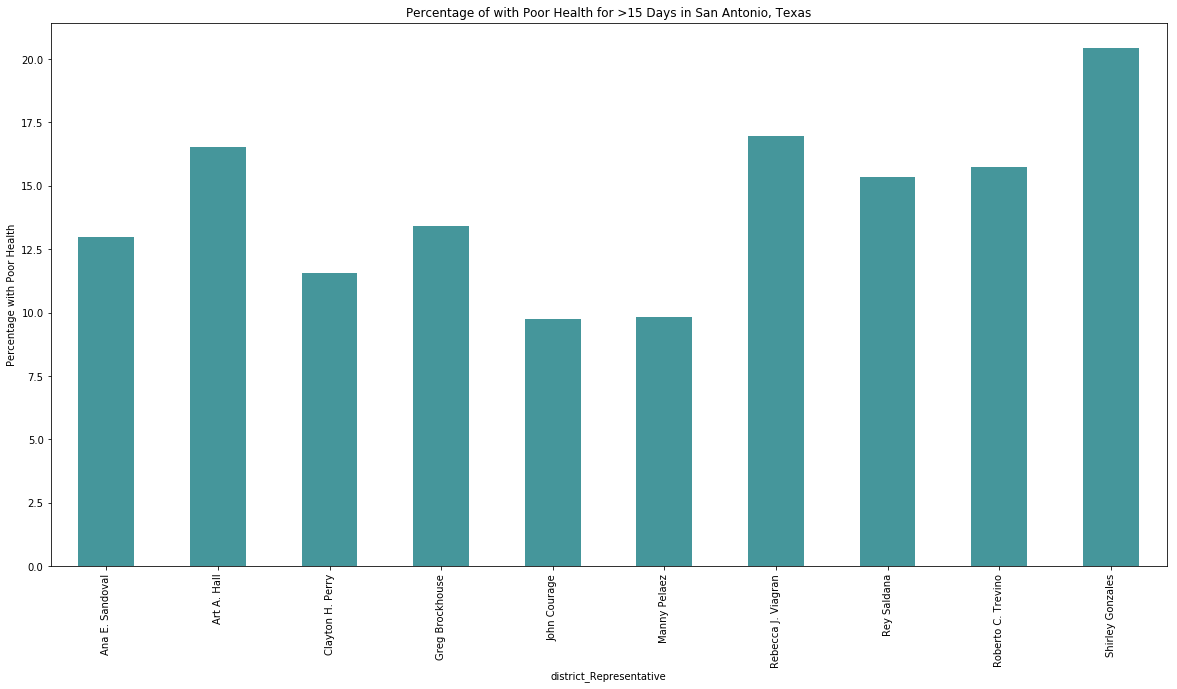

In [25]:
districtDist = combinedFrameWithRestraunts.groupby('district_Representative').mean().iloc[:, 0].plot(kind='bar', figsize=(20, 10), color = '#45969b', title = 'Percentage of with Poor Health for >15 Days in San Antonio, Texas')
districtDist.set_ylabel('Percentage with Poor Health')

The total number of each type of genre was counted for each district to determine which genres were most prevalent in each district

In [26]:
restrautTypesPerDistrict = combinedFrameWithRestraunts.groupby('district_Representative').sum()
restrautTypesPerDistrict.head()

,Percent with Poor Health,latitudes,longitudes,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
district_Representative,,,,,,,,,,,,,,,,,,,,,
Ana E. Sandoval,441.5,1032.310856,-3451.133472,21.0,3.0,9.0,0.0,15.0,0.0,0.0,...,16.0,15.0,16.0,10.0,0.0,0.0,24.0,0.0,3.0,10.0
Art A. Hall,579.0,1089.666831,-3640.786774,49.0,3.0,60.0,2.0,32.0,0.0,10.0,...,19.0,11.0,0.0,2.0,0.0,0.0,31.0,22.0,12.0,3.0
Clayton H. Perry,358.1,916.456442,-3050.507348,19.0,11.0,45.0,0.0,19.0,0.0,0.0,...,27.0,9.0,0.0,8.0,0.0,0.0,56.0,1.0,12.0,1.0
Greg Brockhouse,348.9,913.784137,-3058.748818,50.0,0.0,34.0,0.0,13.0,0.0,0.0,...,21.0,4.0,18.0,0.0,0.0,0.0,13.0,0.0,10.0,33.0
John Courage,311.7,946.959190,-3151.837040,26.0,12.0,9.0,3.0,3.0,0.0,0.0,...,49.0,50.0,0.0,3.0,9.0,0.0,15.0,12.0,0.0,0.0


Bar graphs were created for each district to display the number of each type of genre that was present within each district

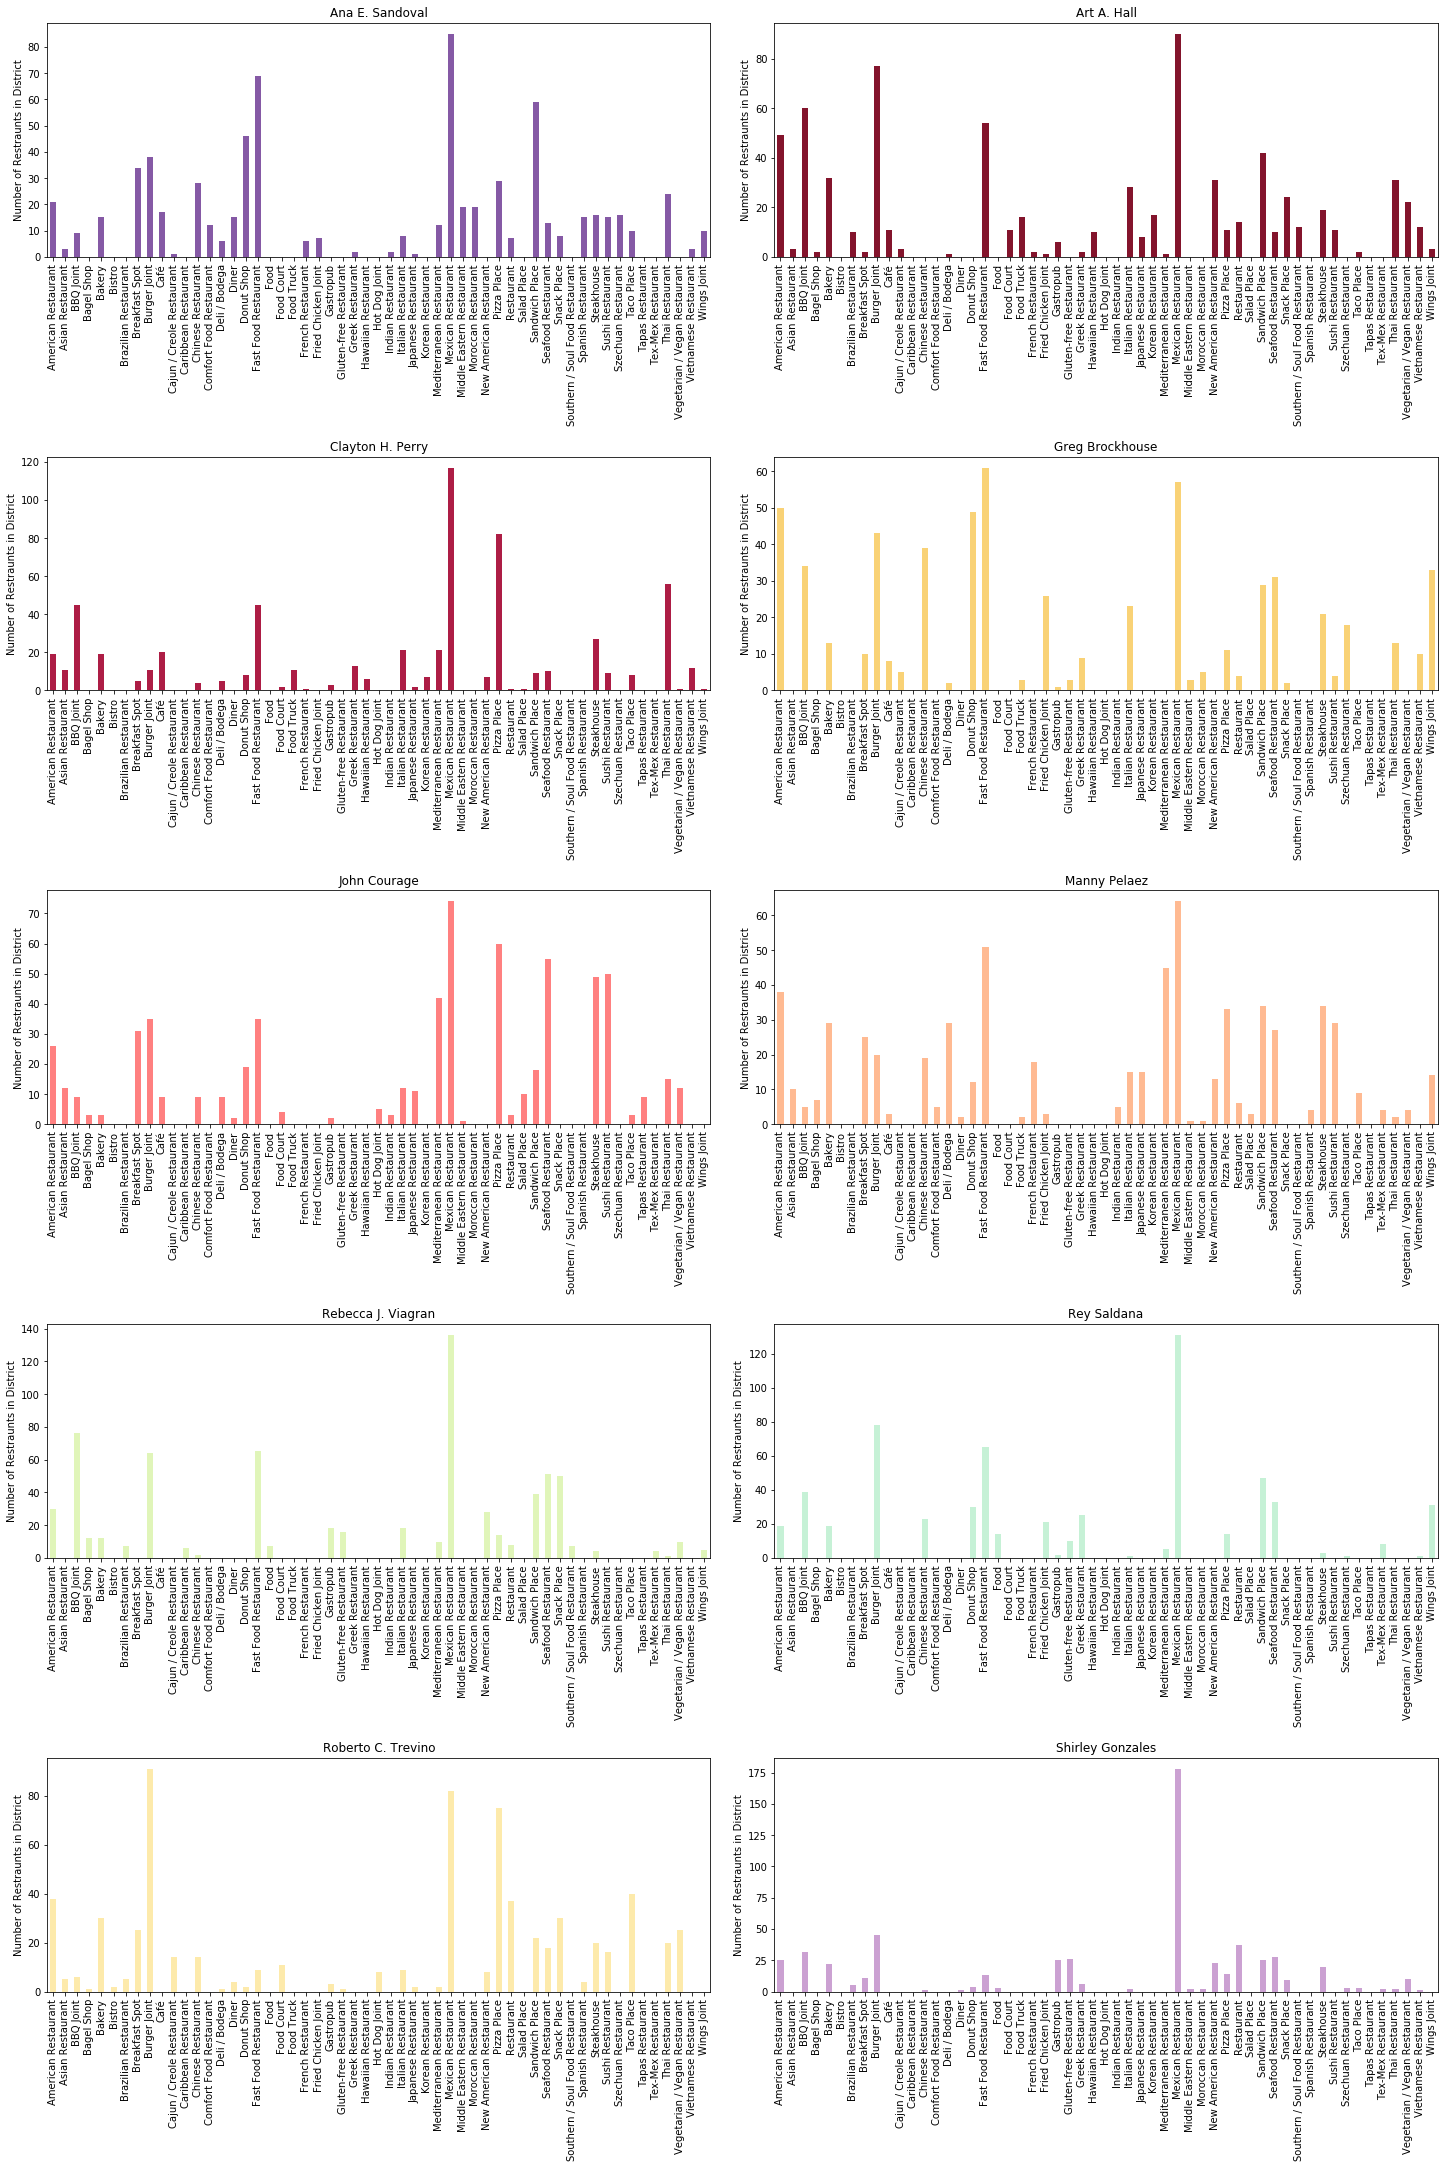

In [27]:
fig, axes = plt.subplots(5, 2, constrained_layout=True, figsize=(20, 30))
colors = ['#8559a5', '#83142c', '#ad1d45', '#f9d276', '#ff8080', '#ffba92', '#e0f5b9', '#c6f1d6', '#fdeaab', '#cba1d2']

for rowNum in range(restrautTypesPerDistrict.shape[0]):
    plt.sca(axes.flat[rowNum]) 
    restrautTypesPerDistrict.iloc[rowNum, 3:].plot(kind='bar', color=colors[rowNum])
    plt.title(f'{restrautTypesPerDistrict.index.values[rowNum]}')
    
    axes.flat[rowNum].set_ylabel('Number of Restraunts in District')

A data frame was created that lists the top five restaurants for each district

In [28]:
topFiveValueDict = {}

for rowNum in range(restrautTypesPerDistrict.shape[0]):
    topFiveValues = restrautTypesPerDistrict.iloc[rowNum, 3:].sort_values(ascending=False)[:5].index
    name = restrautTypesPerDistrict.index.values[rowNum]
    topFiveValueDict[name] = topFiveValues

topFiveFrame = pd.DataFrame.from_dict(topFiveValueDict).transpose()
topFiveFrame = topFiveFrame.rename(columns={0:'Most Common Restraunt', 1:'2nd Most Common Restraunt', 2:'3nd Most Common Restraunt', 3: '4th Most Common Restraunt', 4:'5th Most Common Restraunt'})
topFiveFrame['Average Percent Poor Health'] = combinedFrameWithRestraunts.groupby('district_Representative').mean().iloc[:, 0].values
topFiveFrame = topFiveFrame.sort_values(by=['Average Percent Poor Health'], ascending=False)
topFiveFrame

,Most Common Restraunt,2nd Most Common Restraunt,3nd Most Common Restraunt,4th Most Common Restraunt,5th Most Common Restraunt,Average Percent Poor Health
Shirley Gonzales,Mexican Restaurant,Burger Joint,Restaurant,BBQ Joint,Seafood Restaurant,20.414286
Rebecca J. Viagran,Mexican Restaurant,BBQ Joint,Fast Food Restaurant,Burger Joint,Seafood Restaurant,16.976471
Art A. Hall,Mexican Restaurant,Burger Joint,BBQ Joint,Fast Food Restaurant,American Restaurant,16.542857
Roberto C. Trevino,Burger Joint,Mexican Restaurant,Pizza Place,Taco Place,American Restaurant,15.723529
Rey Saldana,Mexican Restaurant,Burger Joint,Fast Food Restaurant,Sandwich Place,BBQ Joint,15.342308
Greg Brockhouse,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Donut Shop,Burger Joint,13.419231
Ana E. Sandoval,Mexican Restaurant,Fast Food Restaurant,Sandwich Place,Donut Shop,Burger Joint,12.985294
Clayton H. Perry,Mexican Restaurant,Pizza Place,Thai Restaurant,Fast Food Restaurant,BBQ Joint,11.551613
Manny Pelaez,Mexican Restaurant,Fast Food Restaurant,Mediterranean Restaurant,American Restaurant,Steakhouse,9.840625
John Courage,Mexican Restaurant,Pizza Place,Seafood Restaurant,Sushi Restaurant,Steakhouse,9.740625
